# Laboratorium

### Konfiguracja

In [1]:
%matplotlib notebook
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

In [3]:
from copy import deepcopy
from random import uniform

## Wprowadzanie odcinków (żaden odcinek nie może być pionowy)

<IPython.core.display.Javascript object>


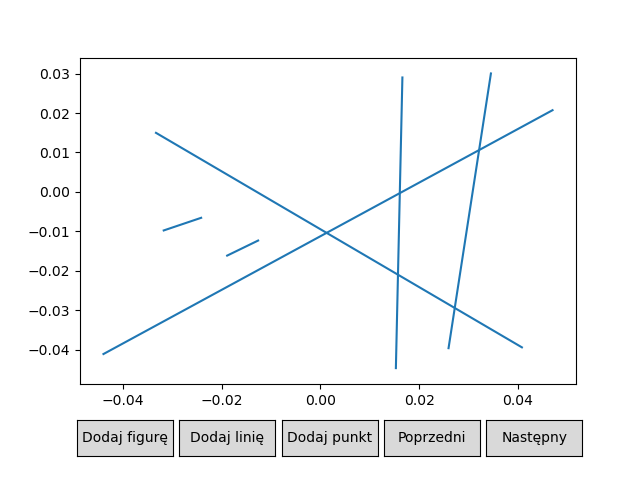

In [115]:
input_plot = Plot()
input_plot.draw()

In [117]:
input_sections = input_plot.get_added_lines()[0].lines
print(input_sections)

for section in input_sections:
    section.sort()

[[(-0.04415524328908614, -0.04117136712167777), (0.047215724452849356, 0.020838436799890878)], [(0.041006047033494517, -0.039486318102069935), (-0.033510081998763555, 0.015109270133224204)], [(-0.03195766264392484, -0.009829455356971883), (-0.02397379167618291, -0.006459357317756195)], [(-0.01909475941811839, -0.016232641631481692), (-0.012441533611666777, -0.01218852398442287)], [(0.015280240581881613, -0.044878474964815035), (0.016610885743171933, 0.02926368189793009)], [(0.025925401872204185, -0.0398233279059915), (0.034574595420591284, 0.030274711309694793)]]


## Generowanie punktów losowo

Po kliknięciu run należy podać 5 współrzędnych oddzielonych spacjami, odpowiednio:
* minX
* minY
* maxX
* maxY
* N - ilość odcinków do wygenerowania

0 0 5 5 5


<IPython.core.display.Javascript object>


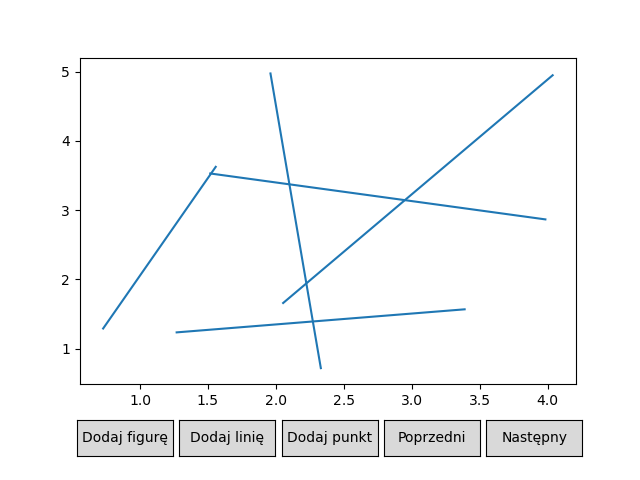

In [127]:
def generate_points(minX, minY, maxX, maxY, N):
    s = []
    points = []
    min_y = INF
    max_y = -INF
    while len(s) < N:
        x1 = uniform(minX, maxX)
        y1 = uniform(minY, maxY)
        
        x2 = uniform(minX, maxX)
        y2 = uniform(minY, maxY)
        
        section = sorted(((x1, y1), (x2, y2)))
        
        if section[0][0] != section[1][0] and (x1, y1) not in points and (x2, y2) not in points:
            s.append(section)
            points = points + [(x1, y1), (x2, y2)]
            min_y = min(min_y, y1, y2)
            max_y = max(max_y, y1, y2)
        
    return s, (min_y, max_y)

minX, minY, maxX, maxY, N = map(float, input().split())
random_sections, random_bounds = generate_points(minX, minY, maxX, maxY, N)

random_plot = Plot([Scene([], [LinesCollection(random_sections)])])
random_plot.draw()

## Funkcje i wartości pomocniczne pomocniczne

In [90]:
from sortedcontainers import SortedSet
EPS = 1e-12
EPS_POINT = 1e-5
INF = 1e15

# funkcja orienta zwraca wyznacznik macierzy postaci
#  | ax, ay, 1 |
#  | bx, by, 1 |
#  | cx, cy, 1 |
# wyznacznik ten definiuje po jakiej stronie (lewo / prawo)
# znajduje się punkt c względem wektora -ab->
def orient(a, b, c):
    return a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - b[1]*c[0] - a[1]*b[0] - a[0]*c[1]

## Klasy section oraz point

In [83]:
# Klasa Point posiada wartości x oraz y wierzchołka
# a także wartość index - w programie używaną
# do określenia, do jakiego odicnka w tablicy 
# należy wierzchołek, wartość None implikuje,
# że wierzchołek jest przecięciem dwóch wierzchołków i 
# nie należy do jednego wierzchołka
class Point():
    def __init__(self, x, y, index, sections = None):
        self.x = x 
        self.y = y   
        self.index = index
        self.sections = sections
    
    # Funkcja zwraca koordynaty x oraz y
    # w dwuelementowej krotce
    def get_coords(self):
        return (self.x, self.y)
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    
class Section():
    def __init__(self, p : Point, q : Point):
        self.p = p
        self.q = q
        self.a = (q.y - p.y) / (q.x - p.x)
        self.b = p.y - self.a * p.x
        self.current_x = p.x
    
    # metoda sprawdzająca wzajemne położenie dwóch wierzchołków
    # jeśli dla obu odcinków zachodzi, że wierzchołki drugiego odcinka leżą 
    # po przeciwnych stronach odcinka pierwszego - oznacza to, że odcinki przecinają się
    # wpp odcinki nie przecinają się
    # położenie wierzchołków względem odcinków badane jest przy użyciu funkcji orient
    # obliczającej wyznacznik z macierzy 3x3
    def check_intersection(self, other):
        o1 = orient(self.p.get_coords(), self.q.get_coords(), other.p.get_coords())
        o2 = orient(self.p.get_coords(), self.q.get_coords(), other.q.get_coords())
        o3 = orient(other.p.get_coords(), other.q.get_coords(), self.p.get_coords())
        o4 = orient(other.p.get_coords(), other.q.get_coords(), self.q.get_coords())
        
        if min(abs(o1), abs(o2), abs(o3), abs(o4)) < EPS:
            return False
        
        s1 = o1 / abs(o1)
        s2 = o2 / abs(o2)
        s3 = o3 / abs(o3)
        s4 = o4 / abs(o4)
        
        return s1 != s2 and s3 != s4
    
    # metoda znajduje dla dwóch przecinających się odcinków punkt ich przecięcia
    # jeśli przekazane odcinki nie przecinają się funckja zwraca dwuelementową krotkę wartości None
    def find_intersection_point(self, other):
        if not self.check_intersection(other):
            return (None, None)
        
        x0 = ((-1)*other.b - (-1)*self.b) / (self.a * (-1) - other.a * (-1))
        y0 = (self.b * other.a - other.b * self.a) / (self.a * (-1) - other.a * (-1))
        return (x0, y0)
    # metoda zwraca parę krotek, gdzie każda krotka zawiera 
    # współrzędne x i y punktu końcowego wierzchołka
    def get_coords(self):
        return (self.p.get_coords(), self.q.get_coords())

    def shorten(self, x):
        if self.q.x > x:
            self.current_x = x
    
    def __eq__(self, other):
        return self.a == other.a and self.b == other.b
    
    def __lt__(self, other):
        x = max(self.current_x, other.current_x)
        return x * self.a + self.b < x * other.a + other.b
    
    def __hash__(self):
        return hash((self.a, self.b))

## Przemapowanie wprowadzonych odcinków

In [8]:
def map_input(sections):
    return [Section(Point(sections[i][0][0], sections[i][0][1], i), Point(sections[i][1][0], sections[i][1][1], i))
            for i in range(len(sections))]

S = map_input(input_sections)

## Implementacja BST (do struktury zdarzeń)

In [105]:
# klasa BSTNode implementuje drzewo BST
# każdy węzeł drzewa BST posiada następujace atrybuty:
#  key - klucz wierzchołka w drzewie BST, w tym wypadku współrzędna x punktu
#  point - obiekt klasy Point (w algorytmie używany do uzyskania dostępu do informacji o danym punkcie)
#  parent - węzeł wierzchołka będącego rodzicem danego wierzchołka w drzewie (wartość None oznacza, 
# że wierzchołek jest korzeniem drzewa)
#  left, right - wskazania na dzieci danego węzła
# dziecko lewe - punkt o mniejszym x od danego węzła
# dziecko prawe - punkt o większym x od danego węzła
class BSTNode():
    def __init__(self, point, parent = None):
        self.key = point.x
        self.point = point
        self.parent = parent
        self.left = None
        self.right = None
    
    # metoda insert jest używana do wstawienia nowego wierzchołka do drzewa
    def insert(self, point):
        if point.x == self.key:
            return False
        if point.x > self.key:
            if self.right == None:
                self.right = BSTNode(point, self)
                return True
            else:
                return self.right.insert(point)
        else:
            if self.left == None:
                self.left = BSTNode(point, self)
                return True
            else:
                return self.left.insert(point)
    
    
# funkcja przenosząca punkty z listy do zrównoważonego drzewa BST
def points_array_to_bst(A, parent = None):
    if not A:
        return None
    mid_index = len(A) // 2
    
    tree_node = BSTNode(A[mid_index], parent)
    tree_node.left = points_array_to_bst(A[:mid_index], tree_node)
    tree_node.right = points_array_to_bst(A[mid_index+1:], tree_node)
    return tree_node

# funkcja znajdująca minimalny klucz w danym drzewie BST
def find_min_bst(root):
    x = root
    prev = None
    while x != None:
        prev = x
        x = x.left
    
    return prev

# funkcja zwracająca następnik danego węzła w drzewie BST
# jeśli brak następnika funkcja zwróci None
def next_bst(node):
    if node.right != None:
        return find_min_bst(node.right)
    
    parent = node.parent
    while parent is not None:
        if node != parent.right:
            break
        node = parent
        parent = parent.parent
    
    return parent

# funkcja wypisująca współrzędne punktów umieszczonych w drzewie BST
# w kolejności inorder (od najmniejszego x do największego x)
def print_inorder(root):
    _min = find_min_bst(root)
    while _min != None:
        print(_min.key)
        _min = next_bst(_min)

## Generowanie struktury zdarzeń

In [10]:
# Funkcja zwraca struktukę zdarzeń w postaci zrównoważonego drzewa BST
def generate_events_structure(S):
    # generowanie posortowanego po wsp. x zbioru punktów z końców wierzchołków
    P = []
    for section in S:
        P.append(section.p)
        P.append(section.q)
    P = sorted(P, key = lambda p : p.x)
    
    Q = points_array_to_bst(P)
    
    return Q

Znalezionych przecięć: 5
Rownania prostych wyrazone są w postaci y = ax + b
Przeciecie w (0.0012488104964341663,-0.010357460450179596) miedzy odcinkami lezacymi na prostych o parametrach:
a1: -0.7326680672268909 b1: -0.00944249687742452a2: 0.6786598134399392 b2: -0.011204977948711444
Przeciecie w (0.01570964602249028,-0.020952452865541087) miedzy odcinkami lezacymi na prostych o parametrach:
a1: 55.71895424836615 b1: -0.8962775008507043a2: -0.7326680672268909 b2: -0.00944249687742452
Przeciecie w (0.01608044673431768,-0.0002918249679685264) miedzy odcinkami lezacymi na prostych o parametrach:
a1: 55.71895424836615 b1: -0.8962775008507043a2: 0.6786598134399392 b2: -0.011204977948711444
Przeciecie w (0.02721382594854057,-0.02938119813699075) miedzy odcinkami lezacymi na prostych o parametrach:
a1: 8.104575163398694 b1: -0.24993769602058755a2: -0.7326680672268909 b2: -0.00944249687742452
Przeciecie w (0.03214859136162952,0.01061297906712889) miedzy odcinkami lezacymi na prostych o paramet

<IPython.core.display.Javascript object>


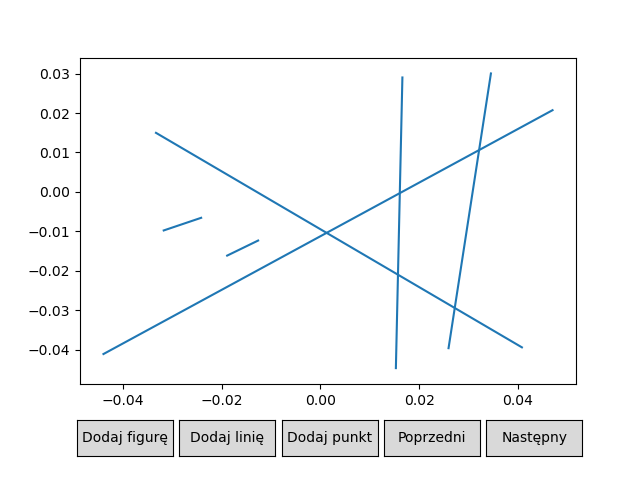

In [122]:
def find_intersections(S, bounds = None):
    sections = map_input(S)
    root_Q = generate_events_structure(sections)
    node = find_min_bst(root_Q)
    state = SortedSet()

    if bounds is None:
        sweep_bounds = (-0.06, 0.06)
    else:
        sweep_bounds = bounds

    scenes = [Scene([], [LinesCollection(S)])]
    end_points = []
    intersections = []
    intersections_details = []

    while node != None:
        curr_point = node.point
        
        if curr_point.index is None:
            index1 = state.index(curr_point.sections[0])
            s1 = state.pop(index1)
            
            index2 = state.index(curr_point.sections[1])
            s2 = state.pop(index2)
            
            
            s1.shorten(curr_point.x + EPS_POINT)
            s2.shorten(curr_point.x + EPS_POINT)

            if s1.a < s2.a:
                s1, s2 = s2, s1
            
            state.add(s1)
            state.add(s2)
            index1 = state.index(s1)
            index2 = state.index(s2)

            if index1 < len(state) - 1:
                neigh = state[index1 + 1]
                x, y = state[index1].find_intersection_point(neigh)
                if x != None:
                    new_point = Point(x, y, None, [s1, neigh])
                    if root_Q.insert(new_point):
                        intersections.append(new_point.get_coords())
                        intersections_details.append((x, y, s1.a, s1.b, neigh.a, neigh.b))
            
            if index2 > 0 :
                neigh = state[index2 - 1]
                x, y = state[index2].find_intersection_point(neigh)
                if x != None:
                    new_point = Point(x, y, None, [s2, neigh])
                    if root_Q.insert(new_point):
                        intersections.append(new_point.get_coords())
                        intersections_details.append((x, y, s1.a, s1.b, neigh.a, neigh.b))
            

        else:
            section = sections[curr_point.index]
            end_points.append(curr_point.get_coords())
            if section not in state:
                state.add(section)
                index = state.index(section)

                if index < len(state) - 1:
                    neigh = state[index+1]
                    x, y = section.find_intersection_point(neigh)
                    if x != None:
                        new_point = Point(x, y, None, [section, neigh])
                        if root_Q.insert(new_point):
                            intersections.append(new_point.get_coords())
                            intersections_details.append((x, y, section.a, section.b, neigh.a, neigh.b))

                if index > 0:
                    neigh = state[index - 1]
                    x, y = section.find_intersection_point(neigh)
                    if x != None:
                        new_point = Point(x, y, None, [section, neigh])
                        if root_Q.insert(new_point):
                            intersections.append(new_point.get_coords())
                            intersections_details.append((x, y, section.a, section.b, neigh.a, neigh.b))
                            
            
            
            else:
                index = state.index(section)
                if index > 0 and index < len(state) - 1:
                    neigh1 = state[index-1]
                    neigh2 = state[index+1]
                    x, y = neigh1.find_intersection_point(neigh2)
                    if x != None:
                        new_point = Point(x, y, None, [neigh1, neigh2])
                        if root_Q.insert(new_point):
                            intersections.append(new_point.get_coords())
                            intersections_details.append((x, y, neigh1.a, neigh1.b, neigh2.a, neigh2.b))

                state.pop(index)
                
        
        node = next_bst(node)

        sweep = ((curr_point.x, sweep_bounds[0]), (curr_point.x, sweep_bounds[1]))

        scenes.append(Scene([
            PointsCollection(deepcopy(end_points)),
            PointsCollection(deepcopy(intersections), color = 'red')], [
            LinesCollection(S),
            LinesCollection([sweep], color = 'red')]))
    
    print('Znalezionych przecięć: ' + str(len(intersections)))
    print('Rownania prostych wyrazone są w postaci y = ax + b')
    for d in intersections_details:
        print('Przeciecie w (' + str(d[0]) + ',' + str(d[1]) + ') miedzy odcinkami lezacymi na prostych o parametrach:\n'
             'a1: ' + str(d[2]) + ' b1: ' + str(d[3]) +
             'a2: ' + str(d[4]) +  ' b2: ' + str(d[5]))
    
    
    return scenes + [Scene([PointsCollection(deepcopy(intersections), color = 'red'),
                            PointsCollection(deepcopy(end_points))],
                            [LinesCollection(S)])]
                        


inter_plot = Plot(find_intersections(input_sections))
inter_plot.draw()

Znalezionych przecięć: 5
Rownania prostych wyrazone są w postaci y = ax + b
Przeciecie w (1.5225242512900632,3.5272515121949173) miedzy odcinkami lezacymi na prostych o parametrach:
a1: -0.26896099227726566 b1: 3.9367511455880937a2: 2.818935683732161 b2: -0.764646429114233
Przeciecie w (2.0994957418065012,3.3720686875899237) miedzy odcinkami lezacymi na prostych o parametrach:
a1: -11.484765812421768 b1: 27.484285606414307a2: -0.26896099227726566 b2: 3.9367511455880937
Przeciecie w (2.9491774444073973,3.1435374537385496) miedzy odcinkami lezacymi na prostych o parametrach:
a1: 1.6588612729467962 b1: -1.7487387958370841a2: -0.26896099227726566 b2: 3.9367511455880937
Przeciecie w (2.224121561908393,1.940770329538689) miedzy odcinkami lezacymi na prostych o parametrach:
a1: -0.26896099227726566 b1: 3.9367511455880937a2: 1.6588612729467962 b2: -1.7487387958370841
Przeciecie w (2.27201533240452,1.390721591516794) miedzy odcinkami lezacymi na prostych o parametrach:
a1: 1.6588612729467962 b1

<IPython.core.display.Javascript object>


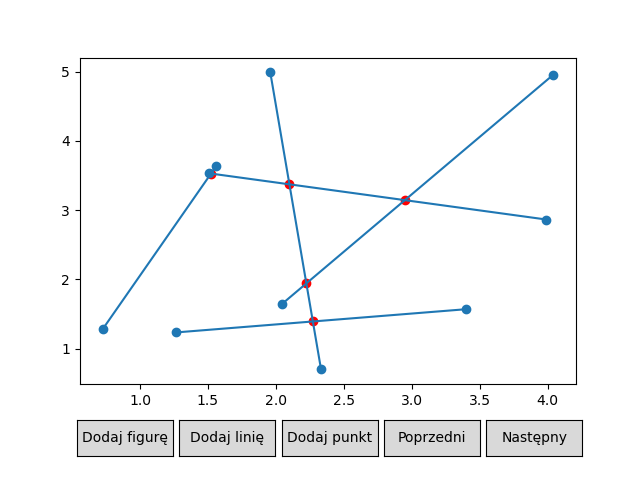

In [128]:
inter_plot = Plot(find_intersections(random_sections, random_bounds))
inter_plot.draw()